<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/childcare_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 子育てスコア
- input
    - public_school_score.csv
        - 幼稚園スコア
    - nursery_score.csv
        - 保育園スコア
- output
    - childcare_score.csv
        - 子育てスコア


In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '子育てスコア'
output_score_file = 'childcare_score.csv'

### 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[[
    '地域ID', '市区町村名', '町名', '町丁目'
]].set_index('地域ID')
print(df_pop_master.shape)

(3145, 3)


### 学校スコア

In [7]:
df_school_score = pd.read_csv(os.path.join(DIR_NAME, 'public_school_score.csv'))[[
    '地域ID',
    '_幼稚園スコア', '幼稚園スコア',
]].set_index('地域ID')
print(df_school_score.shape)

(3145, 2)


In [8]:
df_school_score.head()

,_幼稚園スコア,幼稚園スコア
地域ID,,
101003,0.738384,2.372727
101004,0.710050,2.089091
101005,0.858917,3.408182
101007,0.841715,3.184545
101008,0.882736,3.686364


### 保育園

In [9]:
df_nursery_score = pd.read_csv(os.path.join(DIR_NAME, 'nursery_score.csv'))[[
    '地域ID', '_保育園スコア', '保育園スコア'
]].set_index('地域ID')
print(df_nursery_score.shape)

(3145, 2)


In [10]:
df_nursery_score.head()

,_保育園スコア,保育園スコア
地域ID,,
101003,0.328537,0.148573
101004,0.241613,0.104001
101005,0.338905,0.161307
101007,0.489361,0.473310
101008,0.533646,0.672822


In [11]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

### 教育スコア

In [12]:
df_score = pd.concat([
    df_pop_master,
    df_school_score,
    df_nursery_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_pop_master)

(3145, 7)


In [13]:
print(df_score.shape)
df_score.head()

(3145, 7)


,市区町村名,町名,町丁目,_幼稚園スコア,幼稚園スコア,_保育園スコア,保育園スコア
地域ID,,,,,,,
101003,千代田区,丸の内,丸の内１丁目,0.738384,2.372727,0.328537,0.148573
101004,千代田区,丸の内,丸の内２丁目,0.710050,2.089091,0.241613,0.104001
101005,千代田区,丸の内,丸の内３丁目,0.858917,3.408182,0.338905,0.161307
101007,千代田区,大手町,大手町１丁目,0.841715,3.184545,0.489361,0.473310
101008,千代田区,大手町,大手町２丁目,0.882736,3.686364,0.533646,0.672822


In [14]:
feature_list = {
    '_幼稚園スコア': {'high': True, 'outlier': False, 'weight': 1}, 
    '_保育園スコア': {'high': True, 'outlier': False, 'weight': 1},
}

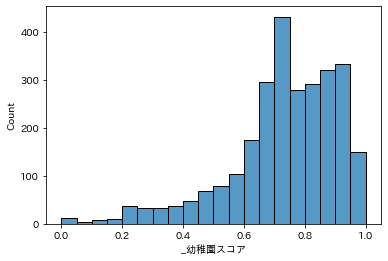

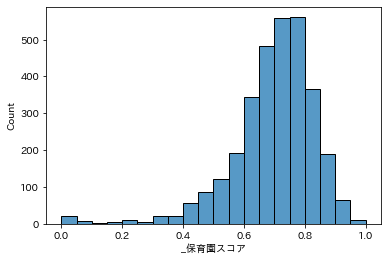

In [15]:
for feature_name in feature_list.keys():
    sns.histplot(df_score[feature_name], bins=20)
    plt.show()

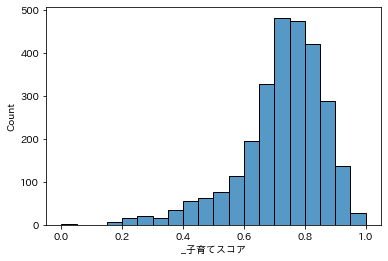

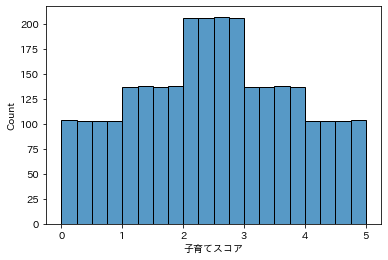

In [16]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_score[key] * value['weight'])

score_sub_name = '_' + score_name
df_score[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_score[score_name] = rank_score(df_score[score_sub_name])

total_score_list = [score_sub_name, score_name]
for _score in total_score_list:
    sns.histplot(df_score[_score], bins=20)
    plt.show()

In [17]:
df_score[
    ['市区町村名', '町丁目'] + list(feature_list.keys()) + total_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=True)

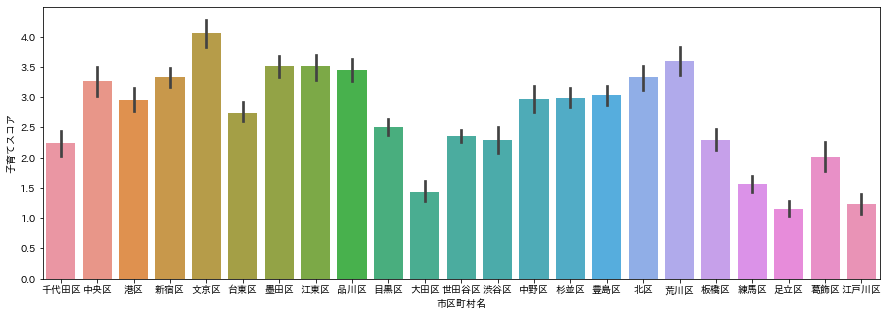

In [18]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_score)
plt.show()

In [19]:
df_level = df_score.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + total_score_list + list(feature_list.keys())
].reset_index(drop=True)
print(df_level.shape)

(851, 7)


In [20]:
df_level.head(20)

,市区町村名,町名,町丁目,_子育てスコア,子育てスコア,_幼稚園スコア,_保育園スコア
0,品川区,西大井,西大井６丁目,1.000000,5.000000,0.969909,0.947157
1,品川区,二葉,二葉４丁目,0.987430,4.997576,0.941337,0.953371
2,文京区,千石,千石１丁目,0.974392,4.992727,0.938538,0.932981
3,文京区,小石川,小石川３丁目,0.973583,4.990303,0.946878,0.923202
4,文京区,水道,水道１丁目,0.970925,4.987879,0.937229,0.928125
5,中央区,日本橋人形町,日本橋人形町３丁目,0.968364,4.985455,0.962761,0.898037
6,文京区,小日向,小日向３丁目,0.967561,4.983030,0.973424,0.885946
7,中央区,日本橋堀留町,日本橋堀留町２丁目,0.965834,4.980606,0.958179,0.898120
8,江東区,白河,白河４丁目,0.964427,4.978182,0.981538,0.872257
9,品川区,中延,中延６丁目,0.964035,4.975758,0.922873,0.930225


In [21]:
df_level.tail(20)

,市区町村名,町名,町丁目,_子育てスコア,子育てスコア,_幼稚園スコア,_保育園スコア
831,大田区,東海,東海１丁目,0.409810,0.247273,0.758729,0.108623
832,大田区,萩中,萩中３丁目,0.409182,0.242424,0.212022,0.654212
833,千代田区,皇居外苑,皇居外苑,0.408817,0.240000,0.802617,0.062968
834,千代田区,千代田,千代田,0.393935,0.215758,0.624086,0.215030
835,足立区,舎人,舎人６丁目,0.391662,0.206061,0.230769,0.604303
836,江戸川区,上篠崎,上篠崎４丁目,0.390032,0.203636,0.368811,0.463363
837,大田区,羽田旭町,羽田旭町,0.382862,0.193939,0.273150,0.546272
838,江戸川区,下篠崎町,下篠崎町,0.382300,0.191515,0.324307,0.494115
839,足立区,加賀,加賀２丁目,0.374544,0.179394,0.153674,0.650953
840,江戸川区,東篠崎町,東篠崎町,0.368910,0.174545,0.312752,0.481855
